## Basic example of use : primary block iteration with Parareal

We want to generate the graph for Parareal with space coarsening (restriction and prolongation frame the coarse solver). First, we need to import the relevant class from the code :

In [1]:
from blockops import BlockOperator, BlockIteration, one

Then define the different block operators, and provide a number of blocks :

In [2]:
nBlocks = 4

g = BlockOperator('G', cost=1)  # coarse solver
f = BlockOperator('F', cost=10)  # fine solver
r = BlockOperator('R', cost=0.2)  # restriction
p = BlockOperator('P', cost=0.2)  # prolongation (interpolation)

Additionnaly, we can provide some rules for our operators. For instance, we use prolongation and restriction operator such that interpolating a coarse field, then applying the restriction again does not modify the coarse field (happen when injection is used for restriction). We have to define the rule like this :

In [3]:
rules = [(r*p, one)]

Now we can define the block iteration of Parareal with space coarsening, that consists on an update formula :

$$u_{n+1}^{k+1} = (F - PGR) u_{n}^k + PGR u_{n}^{k+1}$$

and a predictor formula (to initialize values for $k=0$ :

$$u_{n+1}^{0} = PGR u_{n}^{0}$$

So we instanciate a `BlockIteration` object using both formula (given in positional argument), and add put in named arguments the `locals()` dictionnary to provide the `BlockOperator` variables (and the rules too).

In [4]:
pararealSC = BlockIteration(
    "(f - p*g*r) u_{n}^k + p*g*r * u_{n}^{k+1}",
    "p*g*r u_{n}^k",
    **locals())

Finally, we use the function `plotGraph` to generate the task graph of this block iteration. The task graph depends on the number of time steps `N`, and the number of required iterations per time point `K`. :

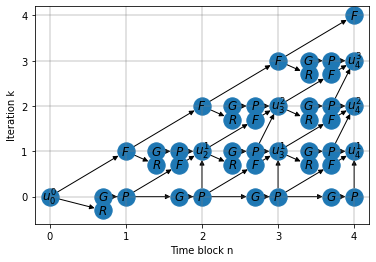

In [5]:
pararealSC.plotGraph(N=nBlocks, K=[0, 1, 2, 3, 4])

Furthermore, we can use the function `speedup(N,K)` to obtain a theoretical minimum lower runtime bound and speedup compared to time stepping for this block iteration and given `N` and `K`.

In [6]:
pararealSC.speedup(N=nBlocks, K=[0, 1, 2, 2, 2])

Block iteration: (f - p*g*r) u_{n}^k + p*g*r * u_{n}^{k+1}
Predictor: p*g*r u_{n}^k
N=4, K=[0, 1, 2, 2, 2]
Theoretical lower runtime bound: 22.799999999999997
Runtime time-stepping: 40 (This is currently not the correct value)
Theoretical speedup compared to time stepping: 1.75 (This is currently not the correct value)


1.7543859649122808

**Info** : the iteration formula can use several times some the $u_{n}^{k}$ terms, that would work too :

In [7]:
pararealSC = BlockIteration(
    "f u_{n}^k + p*g*r * u_{n}^{k+1} - p*g*r u_{n}^{k}",
    "p*g*r u_{n}^k",
    **locals())

**Warning** : even if it makes things quite simple, the use of `locals()` can be dangerous, since all local variables are given in arguments, and some may be changed without knowing. To avoid such issues, it is possible to give every `BlockOperator` variables used for the block iteration as named argument :

In [8]:
pararealSC = BlockIteration(
    "f u_{n}^k + p*g*r * u_{n}^{k+1} - p*g*r u_{n}^{k}",
    "p*g*r u_{n}^k",
    f=BlockOperator('F'), p=BlockOperator('P'), g=BlockOperator('G'), r=BlockOperator('R'),
    rules=[('r*p', one)])

Note that the name of each `BlockOperator` variable must be the same as the variable names given in iteration formulas (but its symbol name given as parameter can be different).

Also, the rules is given as named argument (default to `None`), and can be define either using string (evaluated later) or `BlockOperator` variables.

In particular, not using any rules here does don't allow to simplify predictor step :

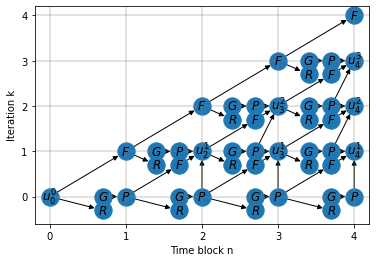

In [9]:
pararealSC = BlockIteration(
    "f u_{n}^k + p*g*r * u_{n}^{k+1} - p*g*r u_{n}^{k}",
    "p*g*r u_{n}^k",
    f=BlockOperator('F'), p=BlockOperator('P'), g=BlockOperator('G'), r=BlockOperator('R'))
pararealSC.plotGraph(N=nBlocks, K=[0, 1, 2, 3, 4])